In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report

In [4]:
df = pd.read_json('./data/SubtaskA/subtaskA_train_monolingual_voice.jsonl', lines=True)

In [5]:
df.describe

<bound method NDFrame.describe of                                           sentence_voices  \
0       {'0': ['Forza Motorsport is a popular racing g...   
1       {'0': ['Buying Virtual Console games for your ...   
2       {'0': ['Windows NT 4.0 was a popular operating...   
3       {'0': ['How to Make Perfume

Perfume is a grea...   
4       {'0': ['How to Convert Song Lyrics to a Song'
...   
...                                                   ...   
119752  {'0': ['The paper is an interesting contributi...   
119753  {'0': ['
We thank the reviewers for all their ...   
119754  {'0': ['The authors introduce a semi-supervise...   
119755  {'0': ['This paper proposes the Neural Graph M...   
119756  {'0': ['The paper proposes a model that aims a...   

                                                     text      id  label  \
0       Forza Motorsport is a popular racing game that...       0      1   
1       Buying Virtual Console games for your Nintendo...       1      1   
2    

In [6]:
def count_active(x):
    count = 0 
    for value in x.values():
        if value[1] == "active":
            count += 1
    return count

df["amount_active"] = df["sentence_voices"].map(lambda x: count_active(x))
df['amount_sentences'] = df["sentence_voices"].map(lambda x: len(x))
df["amount_passive"] = df["amount_sentences"] - df["amount_active"]

In [7]:
df["ratio"] = df["amount_active"] / df["amount_passive"]
df["ratio"].replace([np.inf, -np.inf], 0, inplace=True)
average_ratio = df.groupby("model")["ratio"].mean()
average_ratio 

model
chatGPT    8.641936
cohere     4.491327
davinci    6.187381
dolly      5.539223
human      7.569396
Name: ratio, dtype: float64

# Barplots

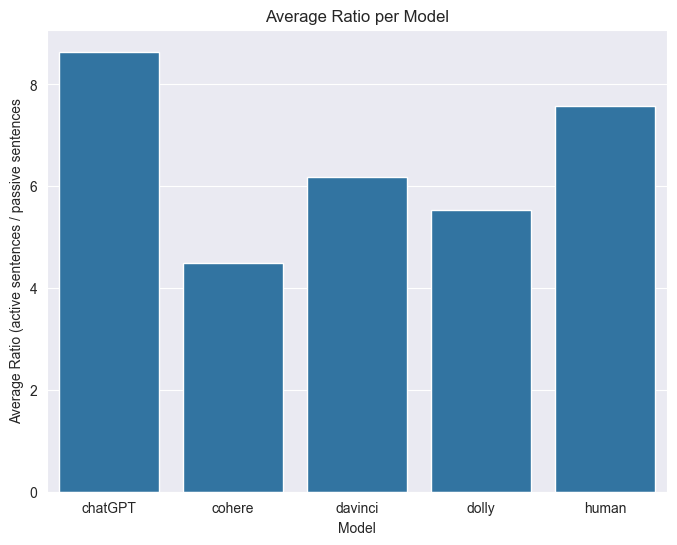

In [6]:
# barplot - model
plt.figure(figsize=(8, 6))
sns.barplot(x='model', y='ratio', data=df, errorbar=None)
plt.xlabel('Model')
plt.ylabel('Average Ratio (active sentences / passive sentences')
plt.title('Average Ratio per Model')
plt.show()

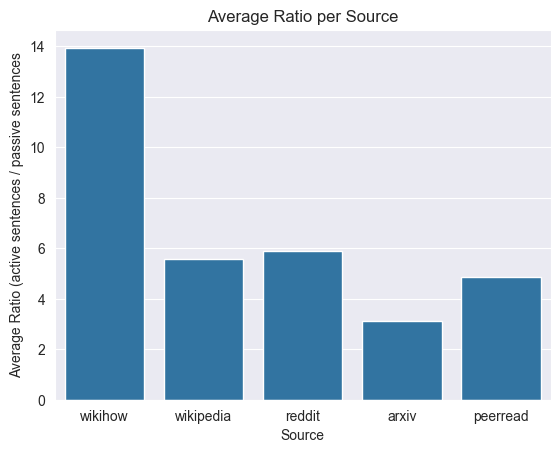

In [7]:
# barplot - source
# plt.figure(figsize=(8, 6))
sns.barplot(x='source', y='ratio', data=df, errorbar=None)
plt.xlabel('Source')
plt.ylabel('Average Ratio (active sentences / passive sentences')
plt.title('Average Ratio per Source')
plt.show()

#  Boxplots

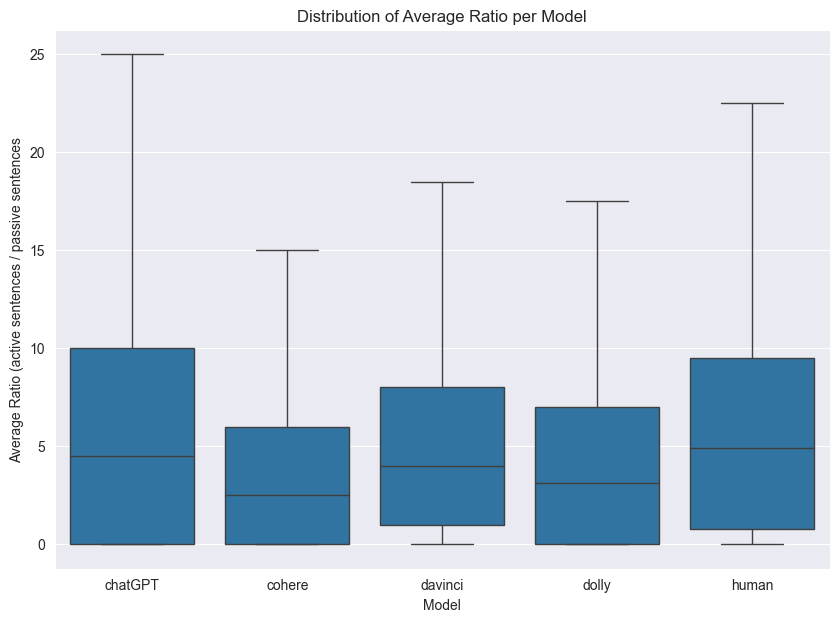

In [8]:
# boxplot - model
plt.figure(figsize=(10, 7))
sns.boxplot(x='model', y='ratio', data=df, showfliers=False)
plt.xlabel('Model')
plt.ylabel('Average Ratio (active sentences / passive sentences')
plt.title('Distribution of Average Ratio per Model')
plt.show()

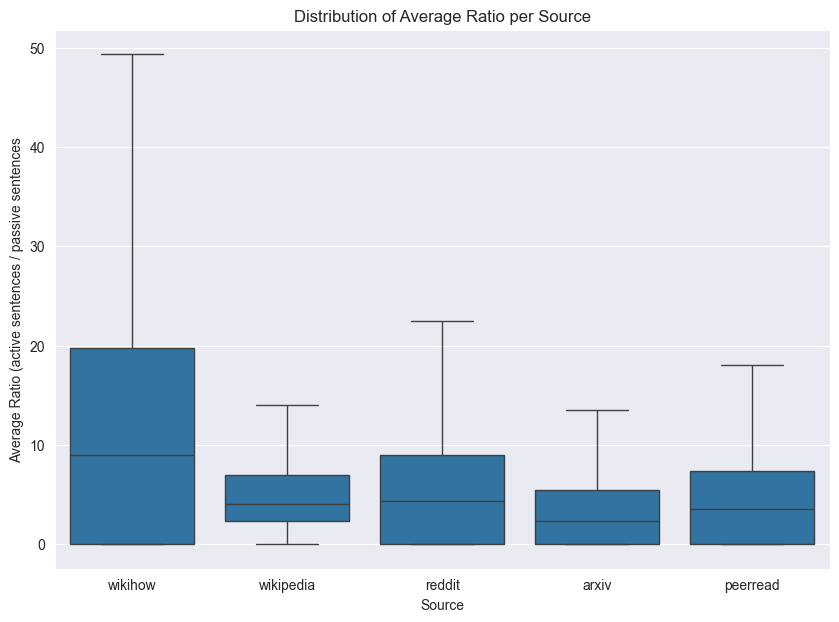

In [9]:
# boxplot - source
plt.figure(figsize=(10, 7))
sns.boxplot(x='source', y='ratio', data=df, showfliers=False)
plt.xlabel('Source')
plt.ylabel('Average Ratio (active sentences / passive sentences')
plt.title('Distribution of Average Ratio per Source')
plt.show()

# SVM

In [8]:
# train model 
# feature: average ratio active sentences / passive sentences
# label to predict: 0 (human) or 1 (machine)
X = df.get(["amount_active", "amount_passive"])
y = df['label']

model = svm.SVC(kernel='linear')

In [9]:
model.fit(X, y)

SVC(kernel='linear')

In [10]:
# calculate average ratio for test data
test_data = pd.read_json('./data/SubtaskA/subtaskA_dev_monolingual_voice.jsonl', lines=True)

test_data["amount_active"] = test_data["sentence_voices"].map(lambda x: count_active(x))
test_data['amount_sentences'] = test_data["sentence_voices"].map(lambda x: len(x))
test_data["amount_passive"] = test_data["amount_sentences"] - test_data["amount_active"]

test_data["ratio"] = test_data["amount_active"] / test_data["amount_passive"]
test_data["ratio"].replace([np.inf, -np.inf], 0, inplace=True)
average_ratio = test_data.groupby("model")["ratio"].mean()
average_ratio 

model
bloomz    3.697165
human     6.546085
Name: ratio, dtype: float64

In [12]:
# predict
X = test_data.get(["amount_active", "amount_passive"])
y_pred = model.predict(X)

# true values
y_true = test_data['label']

In [14]:
# results
result = classification_report(y_true, y_pred)
print("Classification Report:\n", result)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.20      0.33      2500
           1       0.55      0.98      0.71      2500

    accuracy                           0.59      5000
   macro avg       0.73      0.59      0.52      5000
weighted avg       0.73      0.59      0.52      5000
